In [1]:
from MLP import cv_learn, mlp
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
from opart_functions import tune_lldas, SquaredHingeLoss
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def gen_target_from_df(target_df):
    targets_low  = torch.Tensor(target_df.iloc[:, 1:2].to_numpy())
    targets_high = torch.Tensor(target_df.iloc[:, 2:3].to_numpy())
    targets = torch.cat((targets_low, targets_high), dim=1)
    return targets

In [3]:
# features
features_df = pd.read_csv('training_data/genome/seq_features.csv')
chosen_feature = ['std_deviation', 'length', 'sum_diff', 'range_value', 'abs_skewness']
X = features_df.iloc[:, 1:][chosen_feature].to_numpy()
X0 = np.log(X[:, 0]).reshape(-1, 1)
X1 = np.log(np.log(X[:, 1])).reshape(-1, 1)
X2 = np.log(np.log(X[:, 2])).reshape(-1, 1)
X3 = np.log(X[:, 3]).reshape(-1, 1)
X4 = np.log(X[:, 4]).reshape(-1, 1)

X = np.concatenate([X0, X1, X2, X3, X4], axis=1)
mean = np.mean(X, axis=0)
std_dev = np.std(X, axis=0)
X = (X-mean)/std_dev
X = torch.Tensor(X)

In [4]:
# targets
target_df_fold1 = pd.read_csv('training_data/genome/target_fold1.csv')
target_df_fold2 = pd.read_csv('training_data/genome/target_fold2.csv')

In [5]:
y1 = gen_target_from_df(target_df_fold1)
y2 = gen_target_from_df(target_df_fold2)

In [6]:
# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_size):
        super(MLPModel, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

        if self.hidden_layers == 0:
            self.linear_model = nn.Linear(input_size, 1)
        else:
            self.input_layer = nn.Linear(input_size, hidden_size)
            self.hidden = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(hidden_layers - 1)])
            self.output_layer = nn.Linear(hidden_size, 1)
        
        self.initialize_parameters()

    def initialize_parameters(self):
        for param in self.parameters():
            init.constant_(param, 0.5)

    def forward(self, x):
        if self.hidden_layers == 0:
            return self.linear_model(x)
        else:
            x = torch.relu(self.input_layer(x))
            for layer in self.hidden:
                x = torch.relu(layer(x))
            x = self.output_layer(x)
            return x

In [7]:
# function to plot train loss and val loss
def plot_loss(train_loss, val_loss, best_ite, train_set_name, val_set_name):
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss,   'r', label='Validation loss')
    
    # Mark the minimum validation loss point
    if(best_ite != None):
        plt.plot(best_ite, val_loss[best_ite], 'g*', markersize=10, label=f'Min Val epoch: {best_ite: 3d}')

    plt.title('Train ' + train_set_name + " Validate " + val_set_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [17]:
# cross validation to learn the number of iterations
def cv_learn(n_splits, X, y, n_hiddens, layer_size, batch_size, n_ite, show_plot):
    
    # Define the K-fold cross-validation
    kf = KFold(n_splits)

    # loss function
    loss_func = SquaredHingeLoss()

    # learn best ite
    total_losses = {'subtrain': np.zeros(n_ite), 'val': np.zeros(n_ite)}
    data_splits = {'X_subtrain': [], 'X_val': [], 'y_subtrain': [], 'y_val': []}
    
    for subtrain_idx, val_idx in kf.split(X):

        # Split the data into training and validation sets
        indices = {'subtrain': subtrain_idx, 'val': val_idx}
        for key in data_splits.keys():
            feature_target, set_type = key.split('_')       # (X or y) and (subtrain or val)
            data_splits[key].append(X[indices[set_type]] if feature_target == 'X' else y[indices[set_type]])

        # Create DataLoader
        dataset    = TensorDataset(data_splits['X_subtrain'][-1], data_splits['y_subtrain'][-1])
        dataloader = DataLoader(dataset, batch_size, shuffle=False)

        # Define your model
        model = MLPModel(X.shape[1], n_hiddens, layer_size)

        # define optimizer
        optimizer = optim.Adam(model.parameters())

        # Training loop for the specified number of iterations
        for i in range(n_ite):
            # training
            train_loss = 0
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                loss = loss_func(model(inputs), labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                
            # validating
            model.eval()
            with torch.no_grad():
                val_loss = loss_func(model(data_splits['X_val'][-1]), data_splits['y_val'][-1])

            # add train_loss and val_loss into arrays
            total_losses['subtrain'][i] += train_loss/len(dataloader)
            total_losses['val'][i] += val_loss.item()

    best_no_ite = np.argmin(total_losses['val'])
    if(show_plot == True):
        plot_loss(total_losses['subtrain']/n_splits, total_losses['val']/n_splits, best_no_ite, 'subtrain', 'val')
    return best_no_ite + 1

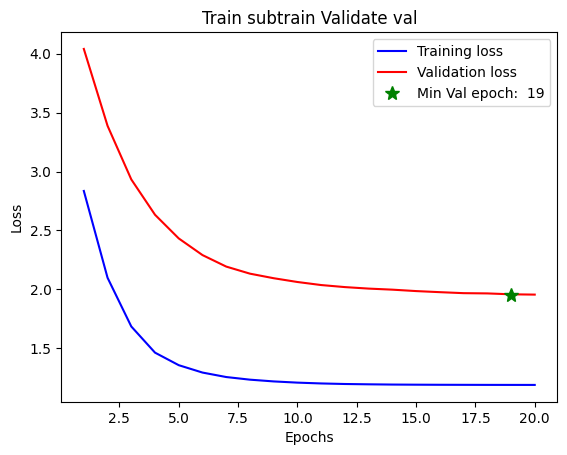

20

In [18]:
cv_learn(2, X, y2, 0, 0, 1, 20, True)

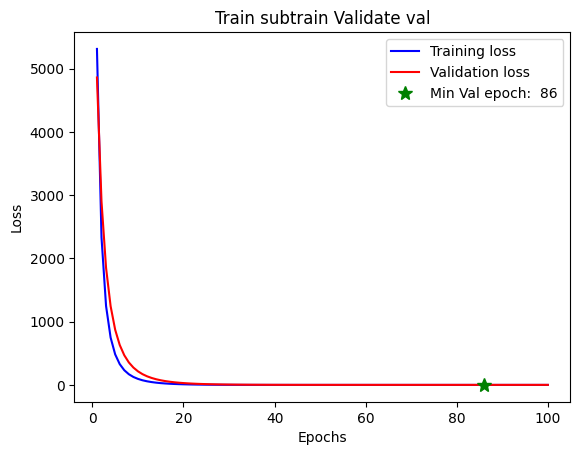

87

In [19]:
cv_learn(2, X, y2, 2, 16, 1, 100, True)